In [3]:
!pip install imblearn
! pip install sqlalchemy
! pip install PyMySQL

In [329]:
# importing some stuff like some useful libraries
import imblearn
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder


In [330]:
engine = pymysql.connect(user='root', password='Parag@123',
                              host='127.0.0.1',database='sakila')

In [331]:
query = """ 
select f.film_id, f.title,f.rental_duration, f.rental_rate, f.length, f.rating,
r.rental_id,r.rental_date, r.customer_id, i.inventory_id, c.name as category,
month(r.rental_date) as active_user_month,
year(r.rental_date) as active_user_year
from sakila.film as f
INNER JOIN sakila.inventory  i 
on i.film_id = f.film_id
INNER JOIN sakila.rental  r 
on r.inventory_id = i.inventory_id
INNER JOIN sakila.category c
on r.customer_id = c.category_id
group by i.film_id

"""
data = pd.read_sql_query(query, engine)
data

,film_id,title,rental_duration,rental_rate,length,rating,rental_id,rental_date,customer_id,inventory_id,category,active_user_month,active_user_year
0,663,PATIENT SISTER,7,0.99,99,NC-17,76,2005-05-25 11:30:37,1,3021,Action,5,2005
1,875,TALENTED HOMICIDE,6,0.99,173,PG,573,2005-05-28 10:35:23,1,4020,Action,5,2005
2,611,MUSKETEERS WAIT,7,4.99,73,PG,1185,2005-06-15 00:54:12,1,2785,Action,6,2005
3,228,DETECTIVE VISION,4,0.99,143,PG-13,1422,2005-06-15 18:02:53,1,1021,Action,6,2005
4,308,FERRIS MOTHER,3,2.99,142,PG,1476,2005-06-15 21:08:46,1,1407,Action,6,2005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,993,WRONG BEHAVIOR,6,2.99,178,PG-13,12104,2005-08-17 22:53:00,16,4551,Travel,8,2005
354,898,TOURIST PELICAN,4,4.99,152,PG-13,12577,2005-08-18 15:39:46,16,4134,Travel,8,2005
355,668,PEAK FOREVER,7,4.99,80,PG,13151,2005-08-19 13:08:23,16,3045,Travel,8,2005
356,917,TUXEDO MILE,3,2.99,152,R,13391,2005-08-19 22:01:42,16,4220,Travel,8,2005


# Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [332]:
# Let's find the shape of the dataframe
data.shape

(358, 13)

In [333]:
# checking null values
data.isna().sum()

film_id              0
title                0
rental_duration      0
rental_rate          0
length               0
rating               0
rental_id            0
rental_date          0
customer_id          0
inventory_id         0
category             0
active_user_month    0
active_user_year     0
dtype: int64

In [334]:
data.describe()

,film_id,rental_duration,rental_rate,length,rental_id,customer_id,inventory_id,active_user_month,active_user_year
count,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000
mean,495.022346,4.896648,2.822402,115.952514,8153.477654,7.854749,2264.326816,7.044693,2005.008380
std,293.188011,1.411414,1.658476,40.851929,4597.952156,4.650366,1343.130868,1.017060,0.091285
min,1.000000,3.000000,0.990000,46.000000,57.000000,1.000000,8.000000,2.000000,2005.000000
25%,245.500000,4.000000,0.990000,80.000000,4176.250000,4.000000,1107.750000,7.000000,2005.000000
50%,488.000000,5.000000,2.990000,117.500000,8496.000000,7.000000,2258.000000,7.000000,2005.000000
75%,738.750000,6.000000,4.990000,150.000000,11928.000000,12.000000,3367.500000,8.000000,2005.000000
max,1000.000000,7.000000,4.990000,185.000000,16045.000000,16.000000,4577.000000,8.000000,2006.000000


In [335]:
# type of each column
data.dtypes

film_id                       int64
title                        object
rental_duration               int64
rental_rate                 float64
length                        int64
rating                       object
rental_id                     int64
rental_date          datetime64[ns]
customer_id                   int64
inventory_id                  int64
category                     object
active_user_month             int64
active_user_year              int64
dtype: object

In [336]:
# the same with film_id
data = data.set_index('film_id')
data

,title,rental_duration,rental_rate,length,rating,rental_id,rental_date,customer_id,inventory_id,category,active_user_month,active_user_year
film_id,,,,,,,,,,,,
663,PATIENT SISTER,7,0.99,99,NC-17,76,2005-05-25 11:30:37,1,3021,Action,5,2005
875,TALENTED HOMICIDE,6,0.99,173,PG,573,2005-05-28 10:35:23,1,4020,Action,5,2005
611,MUSKETEERS WAIT,7,4.99,73,PG,1185,2005-06-15 00:54:12,1,2785,Action,6,2005
228,DETECTIVE VISION,4,0.99,143,PG-13,1422,2005-06-15 18:02:53,1,1021,Action,6,2005
308,FERRIS MOTHER,3,2.99,142,PG,1476,2005-06-15 21:08:46,1,1407,Action,6,2005
...,...,...,...,...,...,...,...,...,...,...,...,...
993,WRONG BEHAVIOR,6,2.99,178,PG-13,12104,2005-08-17 22:53:00,16,4551,Travel,8,2005
898,TOURIST PELICAN,4,4.99,152,PG-13,12577,2005-08-18 15:39:46,16,4134,Travel,8,2005
668,PEAK FOREVER,7,4.99,80,PG,13151,2005-08-19 13:08:23,16,3045,Travel,8,2005


In [337]:
# Get the numeric data into dataframe called numerical and categorical columns in a dataframe called categoricals
numerical = data.select_dtypes(include=np.number)
categoricals = data.select_dtypes(include=np.object)
print('Numerical Data into dataframe:')
display(numerical.head())
print('Categorical Data into dataframe:')
display(categoricals.head())

Numerical Data into dataframe:


C:\Users\parag\AppData\Local\Temp/ipykernel_15304/337146355.py:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categoricals = data.select_dtypes(include=np.object)


,rental_duration,rental_rate,length,rental_id,customer_id,inventory_id,active_user_month,active_user_year
film_id,,,,,,,,
663,7,0.99,99,76,1,3021,5,2005
875,6,0.99,173,573,1,4020,5,2005
611,7,4.99,73,1185,1,2785,6,2005
228,4,0.99,143,1422,1,1021,6,2005
308,3,2.99,142,1476,1,1407,6,2005


Categorical Data into dataframe:


,title,rating,category
film_id,,,
663,PATIENT SISTER,NC-17,Action
875,TALENTED HOMICIDE,PG,Action
611,MUSKETEERS WAIT,PG,Action
228,DETECTIVE VISION,PG-13,Action
308,FERRIS MOTHER,PG,Action


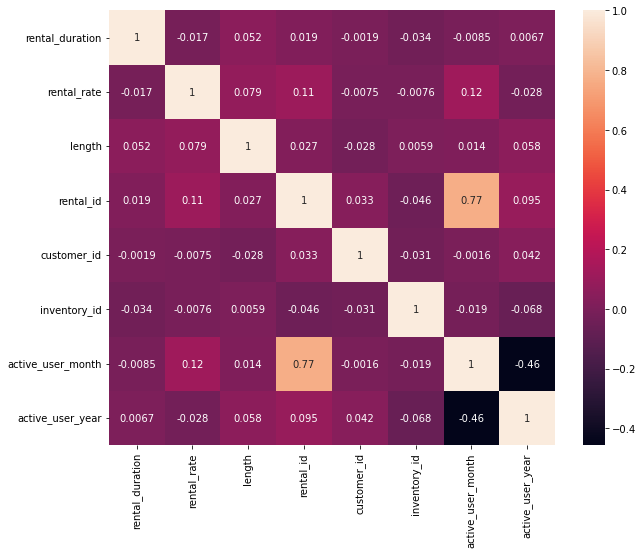

In [338]:
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

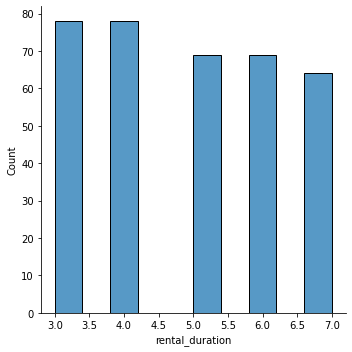

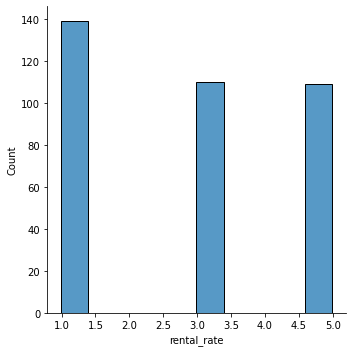

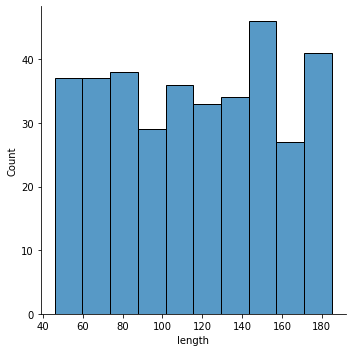

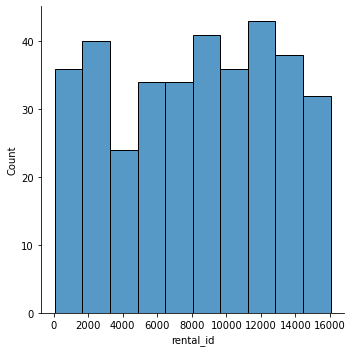

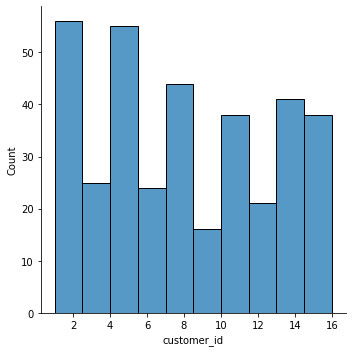

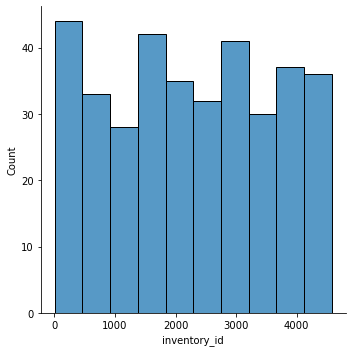

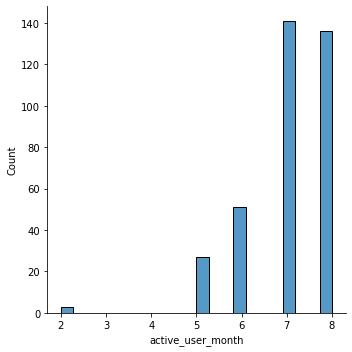

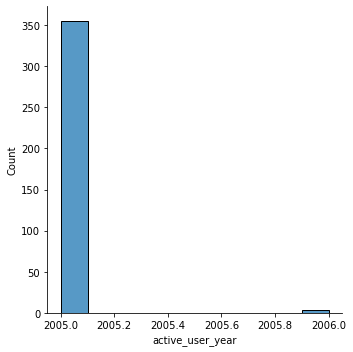

In [339]:
# let's also check the distribution plots of every numerical column
for col in data.select_dtypes(np.number):
    sns.displot(data[col])
    plt.show()

# Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable

In [340]:
query1 ="""select 
title, month(rental_date) as active_user_month
from film as f
left join inventory as i on i.film_id = f.film_id
left join rental as r on r.inventory_id = i.inventory_id
where year(r.rental_date) = 2005;
"""

rental = pd.read_sql_query(query1, engine)

rental

,title,active_user_month
0,ACADEMY DINOSAUR,7
1,ACADEMY DINOSAUR,8
2,ACADEMY DINOSAUR,8
3,ACADEMY DINOSAUR,5
4,ACADEMY DINOSAUR,6
...,...,...
15857,ZORRO ARK,5
15858,ZORRO ARK,6
15859,ZORRO ARK,7
15860,ZORRO ARK,7


In [341]:
rental['active_user_month_may'] = np.where(rental['active_user_month'] == 5,1,0)
rental = rental.groupby(['title'])['active_user_month_may'].max()
rental = pd.DataFrame(rental).reset_index()
rental

,title,active_user_month_may
0,ACADEMY DINOSAUR,1
1,ACE GOLDFINGER,0
2,ADAPTATION HOLES,1
3,AFFAIR PREJUDICE,1
4,AFRICAN EGG,1
...,...,...
953,YOUNG LANGUAGE,0
954,YOUTH KICK,0
955,ZHIVAGO CORE,1
956,ZOOLANDER FICTION,1


In [342]:
data1 = data.join(rental.set_index('title'), on='title')
data1

,title,rental_duration,rental_rate,length,rating,rental_id,rental_date,customer_id,inventory_id,category,active_user_month,active_user_year,active_user_month_may
film_id,,,,,,,,,,,,,
663,PATIENT SISTER,7,0.99,99,NC-17,76,2005-05-25 11:30:37,1,3021,Action,5,2005,1
875,TALENTED HOMICIDE,6,0.99,173,PG,573,2005-05-28 10:35:23,1,4020,Action,5,2005,1
611,MUSKETEERS WAIT,7,4.99,73,PG,1185,2005-06-15 00:54:12,1,2785,Action,6,2005,1
228,DETECTIVE VISION,4,0.99,143,PG-13,1422,2005-06-15 18:02:53,1,1021,Action,6,2005,1
308,FERRIS MOTHER,3,2.99,142,PG,1476,2005-06-15 21:08:46,1,1407,Action,6,2005,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,WRONG BEHAVIOR,6,2.99,178,PG-13,12104,2005-08-17 22:53:00,16,4551,Travel,8,2005,0
898,TOURIST PELICAN,4,4.99,152,PG-13,12577,2005-08-18 15:39:46,16,4134,Travel,8,2005,1
668,PEAK FOREVER,7,4.99,80,PG,13151,2005-08-19 13:08:23,16,3045,Travel,8,2005,1


In [343]:
data1 = data1.select_dtypes(include=np.number)
data1.dtypes

rental_duration            int64
rental_rate              float64
length                     int64
rental_id                  int64
customer_id                int64
inventory_id               int64
active_user_month          int64
active_user_year           int64
active_user_month_may      int32
dtype: object

In [344]:
# X-y split. 

y = data1['active_user_month_may']
X = data1.drop('active_user_month_may', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [345]:
# Apply logistic regression. Fit the model in Supervised learning. 
classification = LogisticRegression(random_state=42) #, max_iter=1000

classification.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [346]:
# checking the score
classification.score(X_test, y_test) 

0.8148148148148148

In [347]:
# to get predictions for our target 'rental_month'
predictions = classification.predict(X_test)
predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [348]:
# to get the probability instead
predictions_ = classification.predict_proba(X_test)
predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [349]:
# Let's find some metrics of the model
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.81      1.00      0.90        88

    accuracy                           0.81       108
   macro avg       0.41      0.50      0.45       108
weighted avg       0.66      0.81      0.73       108



C:\Users\parag\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\parag\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\parag\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [350]:
# constructing the confusion matrix
confusion_matrix(y_test, predictions)

array([[ 0, 20],
       [ 0, 88]], dtype=int64)

<AxesSubplot:>

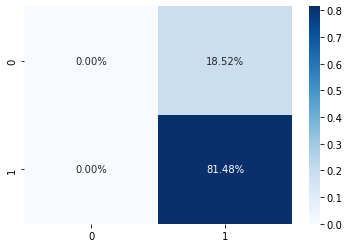

In [351]:
# constructing the confusion matrix
cf_matrix = confusion_matrix(y_test, predictions, normalize='all')
sns.heatmap(cf_matrix, annot=True, fmt='.2%', cmap='Blues')